# install library

In [1]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True
if not ON_KAGGLE:
    import shutil
    from requests import get

    from google.colab import drive, files
    # mount Google Drive
    drive.mount("/content/drive")
else:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

Mounted at /content/drive


In [2]:
if not ON_KAGGLE: 
    !pip uninstall -y kaggle
    !pip install kaggle
    !mkdir /root/.kaggle
    !cp /content/drive/MyDrive/kaggla-za/kaggle.json /root/.kaggle
    !kaggle datasets download -d  kozodoi/timm-pytorch-image-models
    !mkdir -p ../input/timm-pytorch-image-models
    !unzip -n -qq timm-pytorch-image-models.zip -d ../input/timm-pytorch-image-models

    #一回のみ
    # !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    # !mkdir -p ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2
    # !unzip -n -qq animal-imbalance-classification-round2.zip -d ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2

    !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    !mkdir -p ../input/animal-imbalance-classification-round2
    !unzip -n -qq animal-imbalance-classification-round2.zip -d ../input/animal-imbalance-classification-round2


Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 58 kB 2.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=d0ce29ec45acf7d0218c523f1ff65ae6d41ae4f3125f7209ca7fff3a08f9eee5
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
 42% 6.00M/14.3M [00:00<00:00, 59.4MB/s]
100% 14.3M/14.3M [00:00<00:00, 82.2MB/s]
 89% 104M/117M [00:00<00:00, 181MB/s] 
100% 117M/117M [00:00<00:00, 175MB/s]


In [3]:
import sys
sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")

if not ON_KAGGLE:
    !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

import gc
import math
import os
import pickle
import random
import re
import time
import warnings
from contextlib import contextmanager

from pathlib import Path
from PIL import Image

#import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F


#from albumentations.pytorch import ToTensorV2
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

import timm
warnings.filterwarnings('ignore')

     |████████████████████████████████| 117 kB 5.3 MB/s 
     |████████████████████████████████| 948 kB 34.4 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=a4d6e37291528f8c3e14af048d216cc21a26998dfe62704adf835768e781f1e4
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Config


In [4]:
class Config:
    Version = "exp10" # model save時のversion
    MODEL_NAME = "resnet34" # モデル名
    #MODEL_NAME = "efficientnet_b0" # モデル名
    #MODEL_NAME = "efficientnet_b7" # モデル名
    #MODEL_NAME = "resnet50" # モデル名

    if ON_KAGGLE:
        # if MODEL_NAME == 'resnet34':
        #     model_name = '../input/pt-longformer-base' # https://www.kaggle.com/kishalmandal/pt-longformer-base
        # elif MODEL_NAME == 'roberta-base':
        #     model_name = '../input/roberta-base' #https://www.kaggle.com/abhishek/roberta-base
        # elif modeMODEL_NAMEl_savename == 'roberta-large':
        #     model_name = '../input/robertalarge' # https://www.kaggle.com/marshal02/robertalarge
        # elif MODEL_NAME == 'longformer-large':
        #     model_name = '../input/longformerlarge4096' # https://www.kaggle.com/hengzheng/longformerlarge4096 
        #base_dir = '/content/drive/MyDrive/petfinder'
        #data_dir = '../input/digit-recognizer/' # = DATA_PATH
        data_dir = '../input/animal-imbalance-classification-round2' # = DATA_PATH
        pre_data_dir = './preprocessed/'
        model_dir = '.'
        output_dir = '.'   
    else:
        # customize for my own Google Colab Environment
        # if model_savename == 'longformer':
        #     model_name = 'allenai/longformer-base-4096'
        # elif model_savename == 'roberta-base':
        #     model_name = 'roberta-base'
        base_dir = '/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance'
        data_dir = '../input/animal-imbalance-classification-round2' #os.path.join(base_dir, '../input/animal-imbalance-classification-round2')
        #pre_data_dir = os.path.join(base_dir, 'data/preprocessed')
        model_dir = os.path.join(base_dir, f'model/{Version}')
        output_dir = os.path.join(base_dir, f'output/{Version}')    

    is_debug = False
    if MODEL_NAME == 'resnet34':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'roberta-base':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'resnet50':
        size = 64 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    seed = 42 # seed値
    fold = 0
    num_workers = 4  #並列実行する数 was 0
    batch_size =  128 #バッチサイズ was 64 >100
    epochs = 50 #エポック数 10?
    #size = 224 # リサイズした後の画像のサイズ
    #model_lr = 1e-5 # 学習率
    T_max = 10 # 最大イテレーション数 was 10
    min_lr = 1e-3 # 学習率の最小値 was 1e-5
    weight_decay = 1e-6 # 学習減衰値
    max_grad_norm = 1000 # 勾配の最大ノルム
    print_freq = 1000 # 学習結果を表示する頻度
    probability = 0.6
    class_num = 10 
    norms = (0.5, 0.5)
    device = "cuda" if torch.cuda.is_available() else "cpu" # CPU of GPU


In [5]:
if not ON_KAGGLE:
    if not os.path.exists(Config.model_dir):
        !mkdir $Config.model_dir
    if not os.path.exists(Config.output_dir):
        !mkdir $Config.output_dir

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

# Utils

In [7]:
def init_logger(log_file='train.log'):
    """Output Log."""
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def seed_torch(seed=Config.seed): # was seed=0
    """Fixed seed value."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # added trueにすると再現性がなくなる


LOGGER = init_logger()
seed_torch(seed=Config.seed)

In [8]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Dataset

In [9]:
class TrainDataset(Dataset):
    """Dataset used for training."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28) # csv to image
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) # GRAY to RGB

        if self.transform:
            augmented = self.transform(image=image) # augmentation
            image = augmented['image']

        label = self.labels[idx] # 正解ラベル
        return image, label

In [10]:
class TestDataset(Dataset):
    """Dataset used for inference."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28)
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image

# Data Augmentation

In [11]:
def get_transforms(*, data, size, norms):

    if data == 'train':
        return A.Compose([
            A.Resize(Config.size, Config.size), # リサイズ
            A.Rotate(limit=10, border_mode=cv2.BORDER_REPLICATE, p=0.5),
            A.Cutout(num_holes=8, max_h_size=2, max_w_size=2, fill_value=0, p=0.5),
            A.Cutout(num_holes=8, max_h_size=1, max_w_size=1, fill_value=1, p=0.5),
            # A.VerticalFlip(p=0.5),
            # A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0), # 正規化
            ToTensorV2(), # Tensor型に変換
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(Config.size, Config.size),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0),
            ToTensorV2(),
        ])

# Model

In [12]:
# use timm model no pretrained
class BaseModel(nn.Module):
    def __init__(
        self, model_name=Config.MODEL_NAME, n_class=10, pretrained=False
    ):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained) # model load(pretrained=False: 事前学習なし)
        n_features = self.model.fc.in_features
        self.model.classifier = nn.Linear(n_features, n_class) # 出力層の次元をクラス数に変更

    def forward(self, x):
        output = self.model(x)
        return output

# train & valid function

In [13]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.train() # 学習モード
    start = end = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device) # 画像をcpuからgpuヘ
        labels = labels.to(Config.device) # 正解ラベルをcpuからgpuヘ
        batch_size = labels.size(0) 
        y_preds = model(images) # 予測ラベル
        loss = criterion(y_preds, labels) # lossの計算

        losses.update(loss.item(), batch_size) 
        loss.backward() # パラメータの勾配を計算
        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), Config.max_grad_norm)
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))

        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()
    
    return losses.avg

In [14]:
def valid_fn(valid_loader, model, criterion):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device)
        labels = labels.to(Config.device)
        batch_size = labels.size(0)
        with torch.no_grad():
        #with torch.inference_mode(): Pytorch: ^1.9
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)
            
            preds.append(y_preds.softmax(1).to("cpu").numpy().argmax(1))
            del loss
            batch_time.update(time.time() - end)
            end = time.time()
            if step % Config.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                    'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                    step, len(valid_loader), batch_time=batch_time,
                    data_time=data_time, loss=losses,
                    remain=timeSince(start, float(step+1)/len(valid_loader)),
                    ))
        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()

    preds = np.concatenate(preds)

    return losses.avg, preds

# Dataの確認

In [15]:
#data_dir = "../input/digit-recognizer" # ディレクトリパス = data_dir
if ON_KAGGLE:
    train = pd.read_csv(Config.data_dir + "/train.csv") # csvの読み込み
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']
else:
    train = pd.read_csv(f'{Config.data_dir}/train.csv')
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']

train.head()

image_id  label
0  ../input/animal-imbalance-classification-round...      0
1  ../input/animal-imbalance-classification-round...      0
2  ../input/animal-imbalance-classification-round...      0
3  ../input/animal-imbalance-classification-round...      0
4  ../input/animal-imbalance-classification-round...      0

In [16]:
#train['image_id'][0]

In [17]:
import plotly.express as px

target = train.label.value_counts()
#class_num = len(target)

fig = px.pie(target,
             values='label',
             names=target.index,
             hole=.4, 
             width=500, height=500)
fig.update_traces(textinfo='value+label', pull=0.01)
fig.show()

In [18]:
fig = px.bar(target.sort_index().index, target.sort_index(), width=1000, height=400)
fig.show()

# 前処理

### ホールドアウト

In [19]:
f0, f1 = train_test_split(train, test_size=0.2) # 学習用と評価用に分ける
train["folds"] = -1
train.loc[f0.index, "folds"] = 1
train.loc[f1.index, "folds"] = 0
train

image_id  label  folds
0      ../input/animal-imbalance-classification-round...      0      1
1      ../input/animal-imbalance-classification-round...      0      1
2      ../input/animal-imbalance-classification-round...      0      1
3      ../input/animal-imbalance-classification-round...      0      1
4      ../input/animal-imbalance-classification-round...      0      0
...                                                  ...    ...    ...
36495  ../input/animal-imbalance-classification-round...      9      1
36496  ../input/animal-imbalance-classification-round...      9      1
36497  ../input/animal-imbalance-classification-round...      9      1
36498  ../input/animal-imbalance-classification-round...      9      1
36499  ../input/animal-imbalance-classification-round...      9      0

[36500 rows x 3 columns]

#### 平均と標準偏差を計算

In [20]:
#修正部分
# images = train.loc[:, "pixel0": "pixel783"].values.astype(np.uint8).reshape(-1, 28, 28)
# norms = (np.mean(images[train.folds!=0] / 255), np.std(images[train.folds!=0] / 255)) # 平均と標準偏差を計算
# print("平均と標準偏差: ", norms)

#### 画像サイズの確認と数例を表示

In [21]:
# norms = (0.5, 0.5)
# train_dataset = TrainDataset(train,transform=get_transforms(data='train', size=Config.size, norms=Config.norms)) # 学習用のdatasetを作成
# train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
# image_iter = iter(train_loader)
# images, labels = image_iter.next()

In [22]:
# print("height: ", images.shape[1])
# print("weight: ", images.shape[2])

# for n in range(3):
#     fig, axes = plt.subplots(1, 10, figsize=(20, 30))
#     [axes[i].imshow(images[idx]) for i, idx in enumerate(range(n*10, (n+1)*10))]

#     plt.show()

# 学習の際必要になる知識

## 評価指標(Accuracy), Confusion matrix
#### 詳細については、来週説明

## ハイパラメータの用語簡易説明など

> #### * 学習率 : 学習一回当たりの更新量のようなものです。 今回のデフォルトは1e-5です。
> #### * スケジューラー : epoch数に応じて、学習率を変化させるものです。 今回のデフォルトはCosineAnnealingLRです。
> #### * 損失関数: 正解ラベルと予測ラベルの誤差の大きさを計算する関数。 
> #### * 最適化関数: 効率よく損失を減らすための関数。 
> #### * timm : 画像のコンペでpytorchを使う場合にほぼ確実に使用するライブラリですので、見ておきましょう。[github](https://github.com/rwightman/pytorch-image-models)

# 軽めのモデル作成

### モデルの読み込み

In [23]:
model = BaseModel(Config.MODEL_NAME, Config.class_num)
model

BaseModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, m

### 最適化関数

In [24]:
# Adam は勾配を移動平均と学習率の調整からなります (MomentumとRMSProp)
#optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
optimizer = AdamW(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)

### スケジューラ

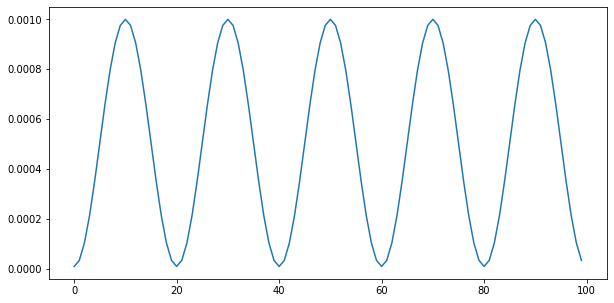

In [25]:
scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=0.001)

log_s = []
for epoch in range(0, 100):
    log_s.append(scheduler.get_last_lr()[0])
    scheduler.step()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(100), log_s)
plt.show()

# 学習

In [26]:
def train_loop(train, fold, class_num=None, norms=(0.5, 0.5)):
    
    train_index = train[train['folds'] != fold].index # 学習用のindex
    valid_index = train[train['folds'] == fold].index # 評価用のindex

    train_dataset = TrainDataset(train.loc[train_index].reset_index(drop=True), 
                                 transform=get_transforms(data='train', size=Config.size, norms=norms)) # 学習用のdatasetを作成
    valid_dataset = TrainDataset(train.loc[valid_index].reset_index(drop=True), 
                                 transform=get_transforms(data='valid', size=Config.size, norms=norms)) # 評価用のdatasetを作成

    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
    valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=False) # 評価用のdatasetsのbatchを作成
    
    
    model = BaseModel(Config.MODEL_NAME, class_num).to(Config.device)

    #optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    optimizer = AdamW(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)

    scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=Config.min_lr, last_epoch=-1)

    criterion = nn.CrossEntropyLoss() # loss function

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(Config.epochs):
        start_time = time.time()
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler) # 学習
        avg_val_loss, predict = valid_fn(valid_loader, model, criterion) # 評価用の推論
        valid_labels = train.loc[valid_index, "label"].values # 予測ラベル
        
        scheduler.step() 
        score = accuracy_score(valid_labels, predict) # 適合率を計算
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            model_filename = f'{Config.model_dir}/{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth'
            torch.save(model.state_dict(), model_filename) # モデルの保存
            #torch.save(model.state_dict(), "./" + f'{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth') # モデルの保存
            print(f'{model_filename} saved')

            valid_folds_predict = predict
            
        del avg_loss, avg_val_loss, valid_labels, predict, score
        gc.collect()
        torch.cuda.empty_cache()

    return valid_folds_predict

In [27]:
preds = train_loop(train, fold=Config.fold, class_num=Config.class_num, norms=Config.norms)

Epoch: [1][0/228] Data 3.470 (3.470) Elapsed 0m 4s (remain 18m 42s) Loss: 6.9555(6.9555) 
Epoch: [1][227/228] Data 0.000 (0.019) Elapsed 2m 3s (remain 0m 0s) Loss: 5.7233(6.2863) 
EVAL: [0/58] Data 1.614 (1.614) Elapsed 0m 1s (remain 1m 41s) Loss: 5.5712(5.5712) 
EVAL: [57/58] Data 0.000 (0.110) Elapsed 0m 15s (remain 0m 0s) Loss: 6.2083(5.6671) 


Epoch 1 - avg_train_loss: 6.2863  avg_val_loss: 5.6671  time: 139s
Epoch 1 - Accuracy: 0.2776712328767123
Epoch 1 - Save Best Score: 0.2777 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp10/resnet34_fold0_best_exp10.pth saved
Epoch: [2][0/228] Data 1.953 (1.953) Elapsed 0m 2s (remain 9m 37s) Loss: 5.6280(5.6280) 
Epoch: [2][227/228] Data 0.000 (0.013) Elapsed 2m 0s (remain 0m 0s) Loss: 2.2526(3.7380) 
EVAL: [0/58] Data 1.393 (1.393) Elapsed 0m 1s (remain 1m 28s) Loss: 1.9948(1.9948) 
EVAL: [57/58] Data 0.000 (0.110) Elapsed 0m 15s (remain 0m 0s) Loss: 4.2431(2.3200) 


Epoch 2 - avg_train_loss: 3.7380  avg_val_loss: 2.3200  time: 137s
Epoch 2 - Accuracy: 0.386986301369863
Epoch 2 - Save Best Score: 0.3870 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp10/resnet34_fold0_best_exp10.pth saved
Epoch: [3][0/228] Data 1.746 (1.746) Elapsed 0m 2s (remain 9m 8s) Loss: 2.2413(2.2413) 
Epoch: [3][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 1.2682(1.6103) 
EVAL: [0/58] Data 1.520 (1.520) Elapsed 0m 1s (remain 1m 36s) Loss: 1.2123(1.2123) 
EVAL: [57/58] Data 0.000 (0.107) Elapsed 0m 15s (remain 0m 0s) Loss: 3.4058(1.3679) 


Epoch 3 - avg_train_loss: 1.6103  avg_val_loss: 1.3679  time: 136s
Epoch 3 - Accuracy: 0.5371232876712329
Epoch 3 - Save Best Score: 0.5371 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp10/resnet34_fold0_best_exp10.pth saved
Epoch: [4][0/228] Data 1.861 (1.861) Elapsed 0m 2s (remain 9m 25s) Loss: 1.3746(1.3746) 
Epoch: [4][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 1.2104(1.2490) 
EVAL: [0/58] Data 1.286 (1.286) Elapsed 0m 1s (remain 1m 22s) Loss: 1.1311(1.1311) 
EVAL: [57/58] Data 0.000 (0.108) Elapsed 0m 15s (remain 0m 0s) Loss: 2.5297(1.1746) 


Epoch 4 - avg_train_loss: 1.2490  avg_val_loss: 1.1746  time: 136s
Epoch 4 - Accuracy: 0.5852054794520548
Epoch 4 - Save Best Score: 0.5852 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp10/resnet34_fold0_best_exp10.pth saved
Epoch: [5][0/228] Data 1.945 (1.945) Elapsed 0m 2s (remain 9m 38s) Loss: 1.0996(1.0996) 
Epoch: [5][227/228] Data 0.000 (0.013) Elapsed 1m 59s (remain 0m 0s) Loss: 0.8567(1.1010) 
EVAL: [0/58] Data 1.203 (1.203) Elapsed 0m 1s (remain 1m 18s) Loss: 0.9277(0.9277) 
EVAL: [57/58] Data 0.000 (0.105) Elapsed 0m 15s (remain 0m 0s) Loss: 2.6224(1.1506) 


Epoch 5 - avg_train_loss: 1.1010  avg_val_loss: 1.1506  time: 136s
Epoch 5 - Accuracy: 0.5893150684931507
Epoch 5 - Save Best Score: 0.5893 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp10/resnet34_fold0_best_exp10.pth saved
Epoch: [6][0/228] Data 1.834 (1.834) Elapsed 0m 2s (remain 9m 9s) Loss: 1.1043(1.1043) 
Epoch: [6][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.9056(0.9721) 
EVAL: [0/58] Data 1.583 (1.583) Elapsed 0m 1s (remain 1m 39s) Loss: 0.3377(0.3377) 
EVAL: [57/58] Data 0.000 (0.105) Elapsed 0m 15s (remain 0m 0s) Loss: 3.0222(1.0246) 


Epoch 6 - avg_train_loss: 0.9721  avg_val_loss: 1.0246  time: 136s
Epoch 6 - Accuracy: 0.6252054794520548
Epoch 6 - Save Best Score: 0.6252 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp10/resnet34_fold0_best_exp10.pth saved
Epoch: [7][0/228] Data 1.771 (1.771) Elapsed 0m 2s (remain 8m 53s) Loss: 0.9358(0.9358) 
Epoch: [7][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.7894(0.8526) 
EVAL: [0/58] Data 1.274 (1.274) Elapsed 0m 1s (remain 1m 22s) Loss: 1.0569(1.0569) 
EVAL: [57/58] Data 0.000 (0.108) Elapsed 0m 15s (remain 0m 0s) Loss: 2.6608(1.0888) 


Epoch 7 - avg_train_loss: 0.8526  avg_val_loss: 1.0888  time: 136s
Epoch 7 - Accuracy: 0.6191780821917808


Epoch: [8][0/228] Data 1.836 (1.836) Elapsed 0m 2s (remain 9m 34s) Loss: 0.6811(0.6811) 
Epoch: [8][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.7914(0.7491) 
EVAL: [0/58] Data 1.653 (1.653) Elapsed 0m 1s (remain 1m 43s) Loss: 0.5529(0.5529) 
EVAL: [57/58] Data 0.000 (0.103) Elapsed 0m 15s (remain 0m 0s) Loss: 2.0188(0.9651) 


Epoch 8 - avg_train_loss: 0.7491  avg_val_loss: 0.9651  time: 135s
Epoch 8 - Accuracy: 0.6763013698630137
Epoch 8 - Save Best Score: 0.6763 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp10/resnet34_fold0_best_exp10.pth saved
Epoch: [9][0/228] Data 1.777 (1.777) Elapsed 0m 2s (remain 9m 8s) Loss: 0.7320(0.7320) 
Epoch: [9][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.5821(0.6424) 
EVAL: [0/58] Data 1.174 (1.174) Elapsed 0m 1s (remain 1m 16s) Loss: 0.4826(0.4826) 
EVAL: [57/58] Data 0.000 (0.104) Elapsed 0m 15s (remain 0m 0s) Loss: 0.4966(0.7776) 


Epoch 9 - avg_train_loss: 0.6424  avg_val_loss: 0.7776  time: 135s
Epoch 9 - Accuracy: 0.7373972602739726
Epoch 9 - Save Best Score: 0.7374 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp10/resnet34_fold0_best_exp10.pth saved
Epoch: [10][0/228] Data 1.695 (1.695) Elapsed 0m 2s (remain 8m 55s) Loss: 0.6198(0.6198) 
Epoch: [10][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.6229(0.5520) 
EVAL: [0/58] Data 1.621 (1.621) Elapsed 0m 1s (remain 1m 41s) Loss: 0.3555(0.3555) 
EVAL: [57/58] Data 0.000 (0.106) Elapsed 0m 15s (remain 0m 0s) Loss: 1.8313(0.6190) 


Epoch 10 - avg_train_loss: 0.5520  avg_val_loss: 0.6190  time: 135s
Epoch 10 - Accuracy: 0.7930136986301369
Epoch 10 - Save Best Score: 0.7930 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp10/resnet34_fold0_best_exp10.pth saved
Epoch: [11][0/228] Data 2.062 (2.062) Elapsed 0m 2s (remain 9m 55s) Loss: 0.4417(0.4417) 
Epoch: [11][227/228] Data 0.000 (0.013) Elapsed 2m 0s (remain 0m 0s) Loss: 0.4889(0.4706) 
EVAL: [0/58] Data 1.332 (1.332) Elapsed 0m 1s (remain 1m 25s) Loss: 0.9994(0.9994) 
EVAL: [57/58] Data 0.000 (0.105) Elapsed 0m 15s (remain 0m 0s) Loss: 0.7974(0.6360) 


Epoch 11 - avg_train_loss: 0.4706  avg_val_loss: 0.6360  time: 136s
Epoch 11 - Accuracy: 0.7893150684931507


Epoch: [12][0/228] Data 1.736 (1.736) Elapsed 0m 2s (remain 8m 50s) Loss: 0.3564(0.3564) 
Epoch: [12][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.2920(0.3900) 
EVAL: [0/58] Data 1.227 (1.227) Elapsed 0m 1s (remain 1m 20s) Loss: 0.6237(0.6237) 
EVAL: [57/58] Data 0.000 (0.105) Elapsed 0m 15s (remain 0m 0s) Loss: 0.9508(0.6325) 


Epoch 12 - avg_train_loss: 0.3900  avg_val_loss: 0.6325  time: 135s
Epoch 12 - Accuracy: 0.7954794520547945
Epoch 12 - Save Best Score: 0.7955 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp10/resnet34_fold0_best_exp10.pth saved
Epoch: [13][0/228] Data 1.812 (1.812) Elapsed 0m 2s (remain 9m 26s) Loss: 0.2724(0.2724) 
Epoch: [13][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.2941(0.3236) 
EVAL: [0/58] Data 1.457 (1.457) Elapsed 0m 1s (remain 1m 32s) Loss: 0.1786(0.1786) 
EVAL: [57/58] Data 0.000 (0.101) Elapsed 0m 14s (remain 0m 0s) Loss: 0.1366(0.5536) 


Epoch 13 - avg_train_loss: 0.3236  avg_val_loss: 0.5536  time: 135s
Epoch 13 - Accuracy: 0.8232876712328767
Epoch 13 - Save Best Score: 0.8233 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp10/resnet34_fold0_best_exp10.pth saved
Epoch: [14][0/228] Data 1.598 (1.598) Elapsed 0m 2s (remain 8m 26s) Loss: 0.2699(0.2699) 
Epoch: [14][227/228] Data 0.000 (0.011) Elapsed 1m 59s (remain 0m 0s) Loss: 0.2415(0.2445) 
EVAL: [0/58] Data 1.071 (1.071) Elapsed 0m 1s (remain 1m 10s) Loss: 0.2302(0.2302) 
EVAL: [57/58] Data 0.000 (0.102) Elapsed 0m 14s (remain 0m 0s) Loss: 2.4972(0.7258) 


Epoch 14 - avg_train_loss: 0.2445  avg_val_loss: 0.7258  time: 135s
Epoch 14 - Accuracy: 0.7913698630136986


Epoch: [15][0/228] Data 1.707 (1.707) Elapsed 0m 2s (remain 8m 54s) Loss: 0.2750(0.2750) 
Epoch: [15][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.1232(0.1640) 
EVAL: [0/58] Data 1.154 (1.154) Elapsed 0m 1s (remain 1m 14s) Loss: 0.3331(0.3331) 
EVAL: [57/58] Data 0.000 (0.102) Elapsed 0m 15s (remain 0m 0s) Loss: 1.4488(0.6544) 


Epoch 15 - avg_train_loss: 0.1640  avg_val_loss: 0.6544  time: 135s
Epoch 15 - Accuracy: 0.8158904109589041


Epoch: [16][0/228] Data 1.565 (1.565) Elapsed 0m 2s (remain 8m 30s) Loss: 0.0888(0.0888) 
Epoch: [16][227/228] Data 0.000 (0.011) Elapsed 1m 59s (remain 0m 0s) Loss: 0.1050(0.1018) 
EVAL: [0/58] Data 1.201 (1.201) Elapsed 0m 1s (remain 1m 18s) Loss: 0.4517(0.4517) 
EVAL: [57/58] Data 0.000 (0.101) Elapsed 0m 14s (remain 0m 0s) Loss: 1.1367(0.5568) 


Epoch 16 - avg_train_loss: 0.1018  avg_val_loss: 0.5568  time: 135s
Epoch 16 - Accuracy: 0.8368493150684931
Epoch 16 - Save Best Score: 0.8368 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp10/resnet34_fold0_best_exp10.pth saved
Epoch: [17][0/228] Data 2.016 (2.016) Elapsed 0m 2s (remain 9m 43s) Loss: 0.1208(0.1208) 
Epoch: [17][227/228] Data 0.000 (0.013) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0363(0.0590) 
EVAL: [0/58] Data 1.086 (1.086) Elapsed 0m 1s (remain 1m 10s) Loss: 0.2495(0.2495) 
EVAL: [57/58] Data 0.000 (0.100) Elapsed 0m 14s (remain 0m 0s) Loss: 0.0917(0.5151) 


Epoch 17 - avg_train_loss: 0.0590  avg_val_loss: 0.5151  time: 135s
Epoch 17 - Accuracy: 0.8572602739726027
Epoch 17 - Save Best Score: 0.8573 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp10/resnet34_fold0_best_exp10.pth saved
Epoch: [18][0/228] Data 2.066 (2.066) Elapsed 0m 2s (remain 10m 0s) Loss: 0.0732(0.0732) 
Epoch: [18][227/228] Data 0.000 (0.013) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0265(0.0335) 
EVAL: [0/58] Data 1.398 (1.398) Elapsed 0m 1s (remain 1m 28s) Loss: 0.2185(0.2185) 
EVAL: [57/58] Data 0.000 (0.099) Elapsed 0m 14s (remain 0m 0s) Loss: 0.2294(0.5079) 


Epoch 18 - avg_train_loss: 0.0335  avg_val_loss: 0.5079  time: 135s
Epoch 18 - Accuracy: 0.8591780821917808
Epoch 18 - Save Best Score: 0.8592 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp10/resnet34_fold0_best_exp10.pth saved
Epoch: [19][0/228] Data 1.789 (1.789) Elapsed 0m 2s (remain 9m 11s) Loss: 0.0090(0.0090) 
Epoch: [19][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0295(0.0228) 
EVAL: [0/58] Data 1.278 (1.278) Elapsed 0m 1s (remain 1m 22s) Loss: 0.1535(0.1535) 
EVAL: [57/58] Data 0.000 (0.099) Elapsed 0m 14s (remain 0m 0s) Loss: 0.3117(0.5051) 


Epoch 19 - avg_train_loss: 0.0228  avg_val_loss: 0.5051  time: 135s
Epoch 19 - Accuracy: 0.8649315068493151
Epoch 19 - Save Best Score: 0.8649 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp10/resnet34_fold0_best_exp10.pth saved
Epoch: [20][0/228] Data 1.676 (1.676) Elapsed 0m 2s (remain 8m 41s) Loss: 0.0211(0.0211) 
Epoch: [20][227/228] Data 0.000 (0.011) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0225(0.0168) 
EVAL: [0/58] Data 1.466 (1.466) Elapsed 0m 1s (remain 1m 34s) Loss: 0.1986(0.1986) 
EVAL: [57/58] Data 0.000 (0.100) Elapsed 0m 14s (remain 0m 0s) Loss: 0.1723(0.4945) 


Epoch 20 - avg_train_loss: 0.0168  avg_val_loss: 0.4945  time: 135s
Epoch 20 - Accuracy: 0.8682191780821917
Epoch 20 - Save Best Score: 0.8682 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp10/resnet34_fold0_best_exp10.pth saved
Epoch: [21][0/228] Data 1.960 (1.960) Elapsed 0m 2s (remain 9m 35s) Loss: 0.0167(0.0167) 
Epoch: [21][227/228] Data 0.000 (0.013) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0048(0.0152) 
EVAL: [0/58] Data 1.161 (1.161) Elapsed 0m 1s (remain 1m 15s) Loss: 0.1957(0.1957) 
EVAL: [57/58] Data 0.000 (0.102) Elapsed 0m 15s (remain 0m 0s) Loss: 0.1069(0.4940) 


Epoch 21 - avg_train_loss: 0.0152  avg_val_loss: 0.4940  time: 135s
Epoch 21 - Accuracy: 0.8682191780821917


Epoch: [22][0/228] Data 1.782 (1.782) Elapsed 0m 2s (remain 9m 0s) Loss: 0.0092(0.0092) 
Epoch: [22][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0096(0.0170) 
EVAL: [0/58] Data 1.213 (1.213) Elapsed 0m 1s (remain 1m 18s) Loss: 0.1995(0.1995) 
EVAL: [57/58] Data 0.000 (0.105) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0506(0.4931) 


Epoch 22 - avg_train_loss: 0.0170  avg_val_loss: 0.4931  time: 135s
Epoch 22 - Accuracy: 0.8675342465753425


Epoch: [23][0/228] Data 1.977 (1.977) Elapsed 0m 2s (remain 9m 31s) Loss: 0.0148(0.0148) 
Epoch: [23][227/228] Data 0.000 (0.013) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0492(0.0165) 
EVAL: [0/58] Data 1.362 (1.362) Elapsed 0m 1s (remain 1m 27s) Loss: 0.2286(0.2286) 
EVAL: [57/58] Data 0.000 (0.101) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0470(0.5167) 


Epoch 23 - avg_train_loss: 0.0165  avg_val_loss: 0.5167  time: 135s
Epoch 23 - Accuracy: 0.8647945205479453


Epoch: [24][0/228] Data 1.910 (1.910) Elapsed 0m 2s (remain 9m 24s) Loss: 0.0151(0.0151) 
Epoch: [24][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0295(0.0276) 
EVAL: [0/58] Data 1.154 (1.154) Elapsed 0m 1s (remain 1m 15s) Loss: 0.3298(0.3298) 
EVAL: [57/58] Data 0.000 (0.095) Elapsed 0m 14s (remain 0m 0s) Loss: 0.5446(0.5674) 


Epoch 24 - avg_train_loss: 0.0276  avg_val_loss: 0.5674  time: 134s
Epoch 24 - Accuracy: 0.8532876712328767


Epoch: [25][0/228] Data 1.885 (1.885) Elapsed 0m 2s (remain 9m 27s) Loss: 0.0274(0.0274) 
Epoch: [25][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0858(0.0598) 
EVAL: [0/58] Data 1.343 (1.343) Elapsed 0m 1s (remain 1m 26s) Loss: 0.2405(0.2405) 
EVAL: [57/58] Data 0.000 (0.101) Elapsed 0m 14s (remain 0m 0s) Loss: 0.2178(0.6668) 


Epoch 25 - avg_train_loss: 0.0598  avg_val_loss: 0.6668  time: 135s
Epoch 25 - Accuracy: 0.836986301369863


Epoch: [26][0/228] Data 1.728 (1.728) Elapsed 0m 2s (remain 8m 57s) Loss: 0.0663(0.0663) 
Epoch: [26][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.1109(0.1035) 
EVAL: [0/58] Data 1.224 (1.224) Elapsed 0m 1s (remain 1m 19s) Loss: 0.5001(0.5001) 
EVAL: [57/58] Data 0.000 (0.098) Elapsed 0m 14s (remain 0m 0s) Loss: 0.0093(0.7770) 


Epoch 26 - avg_train_loss: 0.1035  avg_val_loss: 0.7770  time: 135s
Epoch 26 - Accuracy: 0.807945205479452


Epoch: [27][0/228] Data 1.743 (1.743) Elapsed 0m 2s (remain 9m 5s) Loss: 0.0142(0.0142) 
Epoch: [27][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.1984(0.1104) 
EVAL: [0/58] Data 1.432 (1.432) Elapsed 0m 1s (remain 1m 31s) Loss: 0.4722(0.4722) 
EVAL: [57/58] Data 0.000 (0.101) Elapsed 0m 14s (remain 0m 0s) Loss: 0.8568(0.6912) 


Epoch 27 - avg_train_loss: 0.1104  avg_val_loss: 0.6912  time: 135s
Epoch 27 - Accuracy: 0.8234246575342465


Epoch: [28][0/228] Data 1.628 (1.628) Elapsed 0m 2s (remain 8m 38s) Loss: 0.0684(0.0684) 
Epoch: [28][227/228] Data 0.000 (0.011) Elapsed 1m 59s (remain 0m 0s) Loss: 0.2932(0.1342) 
EVAL: [0/58] Data 1.149 (1.149) Elapsed 0m 1s (remain 1m 15s) Loss: 0.2711(0.2711) 
EVAL: [57/58] Data 0.000 (0.100) Elapsed 0m 14s (remain 0m 0s) Loss: 3.2852(0.6398) 


Epoch 28 - avg_train_loss: 0.1342  avg_val_loss: 0.6398  time: 134s
Epoch 28 - Accuracy: 0.825068493150685


Epoch: [29][0/228] Data 1.535 (1.535) Elapsed 0m 2s (remain 7m 50s) Loss: 0.0777(0.0777) 
Epoch: [29][227/228] Data 0.000 (0.011) Elapsed 1m 58s (remain 0m 0s) Loss: 0.0782(0.1109) 
EVAL: [0/58] Data 1.098 (1.098) Elapsed 0m 1s (remain 1m 11s) Loss: 0.6992(0.6992) 
EVAL: [57/58] Data 0.000 (0.100) Elapsed 0m 14s (remain 0m 0s) Loss: 4.1769(0.7837) 


Epoch 29 - avg_train_loss: 0.1109  avg_val_loss: 0.7837  time: 134s
Epoch 29 - Accuracy: 0.8087671232876712


Epoch: [30][0/228] Data 1.975 (1.975) Elapsed 0m 2s (remain 9m 27s) Loss: 0.1053(0.1053) 
Epoch: [30][227/228] Data 0.000 (0.013) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0690(0.1058) 
EVAL: [0/58] Data 1.141 (1.141) Elapsed 0m 1s (remain 1m 15s) Loss: 0.2141(0.2141) 
EVAL: [57/58] Data 0.000 (0.098) Elapsed 0m 14s (remain 0m 0s) Loss: 1.3969(0.6611) 


Epoch 30 - avg_train_loss: 0.1058  avg_val_loss: 0.6611  time: 135s
Epoch 30 - Accuracy: 0.8253424657534246


Epoch: [31][0/228] Data 1.628 (1.628) Elapsed 0m 2s (remain 8m 35s) Loss: 0.1233(0.1233) 
Epoch: [31][227/228] Data 0.000 (0.011) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0592(0.0839) 
EVAL: [0/58] Data 1.431 (1.431) Elapsed 0m 1s (remain 1m 31s) Loss: 0.1471(0.1471) 
EVAL: [57/58] Data 0.000 (0.098) Elapsed 0m 14s (remain 0m 0s) Loss: 0.1109(0.7580) 


Epoch 31 - avg_train_loss: 0.0839  avg_val_loss: 0.7580  time: 135s
Epoch 31 - Accuracy: 0.8186301369863014


Epoch: [32][0/228] Data 1.688 (1.688) Elapsed 0m 2s (remain 8m 34s) Loss: 0.0949(0.0949) 
Epoch: [32][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0858(0.0732) 
EVAL: [0/58] Data 1.199 (1.199) Elapsed 0m 1s (remain 1m 18s) Loss: 0.1799(0.1799) 
EVAL: [57/58] Data 0.000 (0.098) Elapsed 0m 14s (remain 0m 0s) Loss: 0.5155(0.7973) 


Epoch 32 - avg_train_loss: 0.0732  avg_val_loss: 0.7973  time: 135s
Epoch 32 - Accuracy: 0.8193150684931507


Epoch: [33][0/228] Data 1.669 (1.669) Elapsed 0m 2s (remain 8m 44s) Loss: 0.1901(0.1901) 
Epoch: [33][227/228] Data 0.000 (0.011) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0455(0.0628) 
EVAL: [0/58] Data 1.368 (1.368) Elapsed 0m 1s (remain 1m 27s) Loss: 0.2362(0.2362) 
EVAL: [57/58] Data 0.000 (0.100) Elapsed 0m 15s (remain 0m 0s) Loss: 0.1623(0.6942) 


Epoch 33 - avg_train_loss: 0.0628  avg_val_loss: 0.6942  time: 135s
Epoch 33 - Accuracy: 0.834931506849315


Epoch: [34][0/228] Data 1.794 (1.794) Elapsed 0m 2s (remain 9m 3s) Loss: 0.0280(0.0280) 
Epoch: [34][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0431(0.0381) 
EVAL: [0/58] Data 1.078 (1.078) Elapsed 0m 1s (remain 1m 11s) Loss: 0.2061(0.2061) 
EVAL: [57/58] Data 0.000 (0.098) Elapsed 0m 14s (remain 0m 0s) Loss: 1.0640(0.6248) 


Epoch 34 - avg_train_loss: 0.0381  avg_val_loss: 0.6248  time: 135s
Epoch 34 - Accuracy: 0.8517808219178082


Epoch: [35][0/228] Data 1.615 (1.615) Elapsed 0m 2s (remain 8m 33s) Loss: 0.0272(0.0272) 
Epoch: [35][227/228] Data 0.000 (0.011) Elapsed 1m 58s (remain 0m 0s) Loss: 0.0128(0.0265) 
EVAL: [0/58] Data 1.189 (1.189) Elapsed 0m 1s (remain 1m 17s) Loss: 0.5530(0.5530) 
EVAL: [57/58] Data 0.000 (0.101) Elapsed 0m 14s (remain 0m 0s) Loss: 0.0300(0.6529) 


Epoch 35 - avg_train_loss: 0.0265  avg_val_loss: 0.6529  time: 134s
Epoch 35 - Accuracy: 0.8501369863013699


Epoch: [36][0/228] Data 2.015 (2.015) Elapsed 0m 2s (remain 9m 38s) Loss: 0.0075(0.0075) 
Epoch: [36][227/228] Data 0.000 (0.013) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0173(0.0163) 
EVAL: [0/58] Data 1.282 (1.282) Elapsed 0m 1s (remain 1m 22s) Loss: 0.2958(0.2958) 
EVAL: [57/58] Data 0.000 (0.094) Elapsed 0m 14s (remain 0m 0s) Loss: 0.2833(0.6156) 


Epoch 36 - avg_train_loss: 0.0163  avg_val_loss: 0.6156  time: 135s
Epoch 36 - Accuracy: 0.8610958904109589


Epoch: [37][0/228] Data 1.745 (1.745) Elapsed 0m 2s (remain 8m 59s) Loss: 0.0039(0.0039) 
Epoch: [37][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0175(0.0114) 
EVAL: [0/58] Data 1.205 (1.205) Elapsed 0m 1s (remain 1m 18s) Loss: 0.2621(0.2621) 
EVAL: [57/58] Data 0.000 (0.101) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0005(0.5919) 


Epoch 37 - avg_train_loss: 0.0114  avg_val_loss: 0.5919  time: 135s
Epoch 37 - Accuracy: 0.8668493150684932


Epoch: [38][0/228] Data 1.677 (1.677) Elapsed 0m 2s (remain 8m 21s) Loss: 0.0031(0.0031) 
Epoch: [38][227/228] Data 0.000 (0.011) Elapsed 1m 58s (remain 0m 0s) Loss: 0.0017(0.0061) 
EVAL: [0/58] Data 1.203 (1.203) Elapsed 0m 1s (remain 1m 17s) Loss: 0.3595(0.3595) 
EVAL: [57/58] Data 0.000 (0.097) Elapsed 0m 14s (remain 0m 0s) Loss: 0.0490(0.5944) 


Epoch 38 - avg_train_loss: 0.0061  avg_val_loss: 0.5944  time: 134s
Epoch 38 - Accuracy: 0.8652054794520548


Epoch: [39][0/228] Data 1.918 (1.918) Elapsed 0m 2s (remain 9m 28s) Loss: 0.0068(0.0068) 
Epoch: [39][227/228] Data 0.000 (0.013) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0020(0.0048) 
EVAL: [0/58] Data 1.270 (1.270) Elapsed 0m 1s (remain 1m 22s) Loss: 0.2587(0.2587) 
EVAL: [57/58] Data 0.000 (0.101) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0109(0.5806) 


Epoch 39 - avg_train_loss: 0.0048  avg_val_loss: 0.5806  time: 135s
Epoch 39 - Accuracy: 0.8719178082191781
Epoch 39 - Save Best Score: 0.8719 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp10/resnet34_fold0_best_exp10.pth saved
Epoch: [40][0/228] Data 1.691 (1.691) Elapsed 0m 2s (remain 8m 46s) Loss: 0.0006(0.0006) 
Epoch: [40][227/228] Data 0.000 (0.011) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0057(0.0039) 
EVAL: [0/58] Data 1.215 (1.215) Elapsed 0m 1s (remain 1m 19s) Loss: 0.2716(0.2716) 
EVAL: [57/58] Data 0.000 (0.102) Elapsed 0m 14s (remain 0m 0s) Loss: 0.0091(0.5782) 


Epoch 40 - avg_train_loss: 0.0039  avg_val_loss: 0.5782  time: 135s
Epoch 40 - Accuracy: 0.8715068493150685


Epoch: [41][0/228] Data 1.698 (1.698) Elapsed 0m 2s (remain 8m 46s) Loss: 0.0006(0.0006) 
Epoch: [41][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0008(0.0038) 
EVAL: [0/58] Data 1.120 (1.120) Elapsed 0m 1s (remain 1m 13s) Loss: 0.2627(0.2627) 
EVAL: [57/58] Data 0.000 (0.100) Elapsed 0m 15s (remain 0m 0s) Loss: 0.0155(0.5803) 


Epoch 41 - avg_train_loss: 0.0038  avg_val_loss: 0.5803  time: 135s
Epoch 41 - Accuracy: 0.8679452054794521


Epoch: [42][0/228] Data 1.877 (1.877) Elapsed 0m 2s (remain 9m 14s) Loss: 0.0016(0.0016) 
Epoch: [42][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0025(0.0034) 
EVAL: [0/58] Data 1.257 (1.257) Elapsed 0m 1s (remain 1m 21s) Loss: 0.3090(0.3090) 
EVAL: [57/58] Data 0.000 (0.099) Elapsed 0m 14s (remain 0m 0s) Loss: 0.0146(0.5754) 


Epoch 42 - avg_train_loss: 0.0034  avg_val_loss: 0.5754  time: 135s
Epoch 42 - Accuracy: 0.8710958904109589


Epoch: [43][0/228] Data 1.988 (1.988) Elapsed 0m 2s (remain 9m 29s) Loss: 0.0023(0.0023) 
Epoch: [43][227/228] Data 0.000 (0.013) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0010(0.0035) 
EVAL: [0/58] Data 1.202 (1.202) Elapsed 0m 1s (remain 1m 18s) Loss: 0.3134(0.3134) 
EVAL: [57/58] Data 0.000 (0.097) Elapsed 0m 14s (remain 0m 0s) Loss: 0.0072(0.5831) 


Epoch 43 - avg_train_loss: 0.0035  avg_val_loss: 0.5831  time: 135s
Epoch 43 - Accuracy: 0.8701369863013698


Epoch: [44][0/228] Data 1.678 (1.678) Elapsed 0m 2s (remain 8m 36s) Loss: 0.0010(0.0010) 
Epoch: [44][227/228] Data 0.000 (0.011) Elapsed 1m 58s (remain 0m 0s) Loss: 0.0019(0.0049) 
EVAL: [0/58] Data 1.319 (1.319) Elapsed 0m 1s (remain 1m 24s) Loss: 0.2818(0.2818) 
EVAL: [57/58] Data 0.000 (0.102) Elapsed 0m 14s (remain 0m 0s) Loss: 0.0022(0.6146) 


Epoch 44 - avg_train_loss: 0.0049  avg_val_loss: 0.6146  time: 134s
Epoch 44 - Accuracy: 0.8675342465753425


Epoch: [45][0/228] Data 1.688 (1.688) Elapsed 0m 2s (remain 8m 42s) Loss: 0.0064(0.0064) 
Epoch: [45][227/228] Data 0.000 (0.011) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0179(0.0123) 
EVAL: [0/58] Data 1.178 (1.178) Elapsed 0m 1s (remain 1m 17s) Loss: 0.5349(0.5349) 
EVAL: [57/58] Data 0.000 (0.100) Elapsed 0m 14s (remain 0m 0s) Loss: 0.0130(0.8102) 


Epoch 45 - avg_train_loss: 0.0123  avg_val_loss: 0.8102  time: 135s
Epoch 45 - Accuracy: 0.8413698630136986


Epoch: [46][0/228] Data 1.654 (1.654) Elapsed 0m 2s (remain 8m 48s) Loss: 0.0073(0.0073) 
Epoch: [46][227/228] Data 0.000 (0.011) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0177(0.0591) 
EVAL: [0/58] Data 1.340 (1.340) Elapsed 0m 1s (remain 1m 26s) Loss: 0.4846(0.4846) 
EVAL: [57/58] Data 0.000 (0.108) Elapsed 0m 15s (remain 0m 0s) Loss: 0.8500(0.7159) 


Epoch 46 - avg_train_loss: 0.0591  avg_val_loss: 0.7159  time: 135s
Epoch 46 - Accuracy: 0.8380821917808219


Epoch: [47][0/228] Data 1.625 (1.625) Elapsed 0m 2s (remain 8m 33s) Loss: 0.0305(0.0305) 
Epoch: [47][227/228] Data 0.000 (0.011) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0724(0.0597) 
EVAL: [0/58] Data 1.449 (1.449) Elapsed 0m 1s (remain 1m 31s) Loss: 0.5714(0.5714) 
EVAL: [57/58] Data 0.000 (0.101) Elapsed 0m 14s (remain 0m 0s) Loss: 2.5155(0.7421) 


Epoch 47 - avg_train_loss: 0.0597  avg_val_loss: 0.7421  time: 135s
Epoch 47 - Accuracy: 0.8372602739726027


Epoch: [48][0/228] Data 1.743 (1.743) Elapsed 0m 2s (remain 8m 47s) Loss: 0.0855(0.0855) 
Epoch: [48][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0090(0.0609) 
EVAL: [0/58] Data 1.226 (1.226) Elapsed 0m 1s (remain 1m 20s) Loss: 0.5934(0.5934) 
EVAL: [57/58] Data 0.000 (0.102) Elapsed 0m 15s (remain 0m 0s) Loss: 1.0044(0.7345) 


Epoch 48 - avg_train_loss: 0.0609  avg_val_loss: 0.7345  time: 135s
Epoch 48 - Accuracy: 0.8410958904109589


Epoch: [49][0/228] Data 1.793 (1.793) Elapsed 0m 2s (remain 9m 0s) Loss: 0.0320(0.0320) 
Epoch: [49][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.1028(0.0601) 
EVAL: [0/58] Data 1.205 (1.205) Elapsed 0m 1s (remain 1m 18s) Loss: 0.5289(0.5289) 
EVAL: [57/58] Data 0.000 (0.101) Elapsed 0m 14s (remain 0m 0s) Loss: 0.6336(0.7041) 


Epoch 49 - avg_train_loss: 0.0601  avg_val_loss: 0.7041  time: 135s
Epoch 49 - Accuracy: 0.8450684931506849


Epoch: [50][0/228] Data 1.721 (1.721) Elapsed 0m 2s (remain 9m 1s) Loss: 0.0189(0.0189) 
Epoch: [50][227/228] Data 0.000 (0.012) Elapsed 1m 59s (remain 0m 0s) Loss: 0.0480(0.0571) 
EVAL: [0/58] Data 1.467 (1.467) Elapsed 0m 1s (remain 1m 32s) Loss: 0.3148(0.3148) 
EVAL: [57/58] Data 0.000 (0.103) Elapsed 0m 14s (remain 0m 0s) Loss: 3.1697(0.7866) 


Epoch 50 - avg_train_loss: 0.0571  avg_val_loss: 0.7866  time: 135s
Epoch 50 - Accuracy: 0.8278082191780822


# 推論

In [28]:
def inference(test, class_num=Config.class_num, n=0, norms=(0.5, 0.5)):
    model = BaseModel(Config.MODEL_NAME, class_num, pretrained=False)

    model.load_state_dict(torch.load(f'{Config.model_dir}/{Config.MODEL_NAME}_fold{n}_best_{Config.Version}.pth')) # 重みの読み込み
    model.to(Config.device)
    
    test_dataset = TestDataset(test, transform=get_transforms(data='valid', size=Config.size, norms=norms))
    test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)
    
    all_predicts = []
    model.eval() # 推論モード
    with torch.no_grad(): # 勾配の計算をしない
        for i, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
            images = images.to(Config.device)
            y_preds = model(images)
            predicts = y_preds.softmax(1).to("cpu").numpy().argmax(1)
            all_predicts.append(predicts)
    
    predicts = np.concatenate(all_predicts)
        
    return predicts

In [29]:
#MODEL_PATH = "./" # 自身の作成したモデルへのPATH

#修正
if ON_KAGGLE:
    #test = pd.read_csv(Config.data_dir + "/test.csv")
    test = pd.read_csv(Config.data_dir + "/sample_submission.csv")
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']
else:
    #test = pd.read_csv(f'{Config.data_dir}/test/test.csv')
    test = pd.read_csv(f'{Config.data_dir}/sample_submission.csv')
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']

In [30]:
predicts = inference(test, class_num=Config.class_num, n=0, norms=Config.norms)

  0%|          | 0/79 [00:00<?, ?it/s]

# 後処理

In [31]:
submit = pd.read_csv(Config.data_dir + "/sample_submission.csv")
submit["label"] = predicts # 提出用csvに書き込み
submit.to_csv('submission.csv', index=False) # csvを書き出す

In [32]:
submit

image_id  label
0        image_0.png      3
1        image_1.png      8
2        image_2.png      8
3        image_3.png      0
4        image_4.png      4
...              ...    ...
9995  image_9995.png      0
9996  image_9996.png      3
9997  image_9997.png      5
9998  image_9998.png      1
9999  image_9999.png      7

[10000 rows x 2 columns]

In [33]:
if not ON_KAGGLE:
    submit.to_csv(f'{Config.output_dir}/{Config.Version}.csv', index=False)